In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, f1_score

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1 О датасете

Имеются данные о клиентах некоторого банка, по которым определяется иx кредитоспособность (1 $~-$ кредит не погашен, 0 $~-$ погашен).

Построим скоринг-модель, которая предсказывает вероятность дефолта клиента.

Клиент из выборки имеет следующие признаки:
* `app_date` дата подачи заявки
* `education` какое образование
* `sex` пол
* `age` возраст
* `car` наличие автомобиля
* `car_type` наличие иномарки
* `decline_app_cnt` количество прошлых отказанных заявок
* `good_work` наличие престижной работы
* `score_bki` скоринговый балл по данным из Бюро Кредитных историй (БКИ)
* `bki_request_cnt` количество запросов в БКИ
* `region_rating` рейтинг региона
* `home_address` категоризатор домашнего адреса
* `work_address` категоризатор рабочего адреса
* `income` прибыль заёмщика
* `sna` связь заемщика с клиентами банка
* `first_time` давность наличия информации о заемщике
* `foreign_passport` наличие загранпаспорта
* `default` дефолт по кредиту

# 2 Импорт данных и предварительный анализ

Считываем данные и удаляем неинформативный признак `client_id`

In [5]:
scoring_df = pd.read_csv('scoring_data.csv', header=0)
del scoring_df['client_id']
scoring_df = scoring_df.sample(frac=1)

In [6]:
scoring_df.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
1890,14MAR2014,SCH,F,36,N,N,0,0,-2.198890,1,50,2,3,150000,1,3,N,0
68585,01FEB2014,SCH,F,30,N,N,0,0,-0.891424,4,80,2,3,23500,2,3,N,1
37891,26APR2014,SCH,M,43,Y,N,1,0,-1.829579,1,60,3,3,50000,1,4,N,0
59481,17JAN2014,SCH,M,41,N,N,0,0,-2.529219,0,80,2,3,34000,1,4,N,0
65543,30JAN2014,SCH,M,23,N,N,1,0,-1.751235,2,80,2,3,35000,1,4,N,0


In [7]:
print(f'Размер всей выборки = {scoring_df.shape}')

Размер всей выборки = (73799, 18)


In [8]:
scoring_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 1890 to 62848
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   app_date          73799 non-null  object 
 1   education         73492 non-null  object 
 2   sex               73799 non-null  object 
 3   age               73799 non-null  int64  
 4   car               73799 non-null  object 
 5   car_type          73799 non-null  object 
 6   decline_app_cnt   73799 non-null  int64  
 7   good_work         73799 non-null  int64  
 8   score_bki         73799 non-null  float64
 9   bki_request_cnt   73799 non-null  int64  
 10  region_rating     73799 non-null  int64  
 11  home_address      73799 non-null  int64  
 12  work_address      73799 non-null  int64  
 13  income            73799 non-null  int64  
 14  sna               73799 non-null  int64  
 15  first_time        73799 non-null  int64  
 16  foreign_passport  73799 non-null  obj

In [9]:
scoring_df.nunique()

app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

Переведем поля `home_address` и `work_address` в тип object, так как это категориальный тип

In [10]:
scoring_df[['home_address', 'work_address']] = scoring_df[['home_address', 'work_address']].astype(object)

Также в поле `education` небольшое количество пропущенных значений, которые можно заполнить модой

In [11]:
print(f'Категории поля `education` : {[ed for ed in scoring_df.education.unique() if isinstance(ed, str)]}')

Категории поля `education` : ['SCH', 'GRD', 'UGR', 'ACD', 'PGR']


In [12]:
ed_mode = scoring_df.education.mode()[0]
print(f'Мода `education` : {ed_mode}')

Мода `education` : SCH


In [13]:
scoring_df.education = scoring_df.education.fillna(ed_mode)

Рассмотрим основные статистики для числовых данных

In [14]:
scoring_df.describe()

,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,41099.775417,1.733330,2.765458,0.126994
std,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,46166.322400,1.123622,1.009463,0.332968
min,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1000.000000,1.000000,1.000000,0.000000
25%,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,20000.000000,1.000000,2.000000,0.000000
50%,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,30000.000000,1.000000,3.000000,0.000000
75%,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,48000.000000,2.000000,4.000000,0.000000
max,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,1000000.000000,4.000000,4.000000,1.000000


а также для категориальных данных

In [15]:
scoring_df.describe(include=object)

,app_date,education,sex,car,car_type,home_address,work_address,foreign_passport
count,73799,73799,73799,73799,73799,73799,73799,73799
unique,120,5,2,2,2,3,3,2
top,18MAR2014,SCH,F,N,N,2,3,N
freq,1018,39167,41562,49832,59791,39956,44959,62733


# 3 Exploratary data analysis (EDA)

Разведочный анализ данных

## 3.1 Target

Изучим целевую переменную

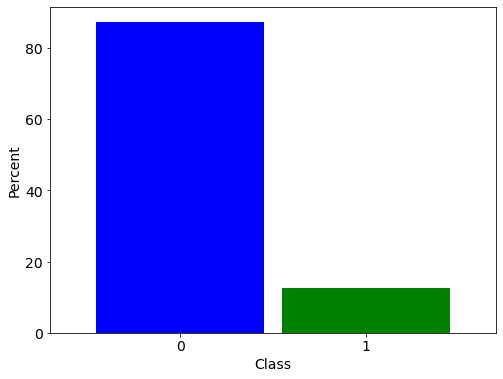

In [16]:
plt.figure(figsize=(8,6))
stat = scoring_df.groupby('default')['default'].agg(lambda x : float(len(x)) * 100/scoring_df.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color=["b","g"])
plt.xticks(rotation=0)
plt.ylabel('Percent', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.show()

Наблюдаем дисбаланс классов, который должен учитываться при обучении модели

## 3.2 Sex

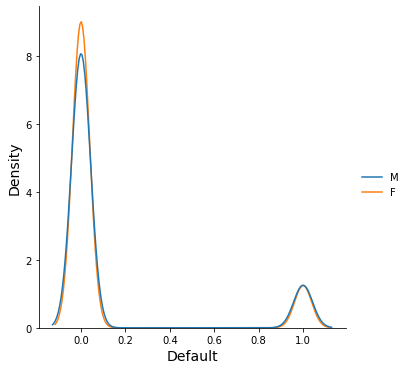

In [17]:
sns.displot({"M": scoring_df[scoring_df.sex == 'M'].default , 
             "F": scoring_df[scoring_df.sex == 'F'].default }, 
            kind='kde', common_norm=False)

plt.ylabel('Density', fontsize=14)
plt.xlabel('Default', fontsize=14)
plt.show()

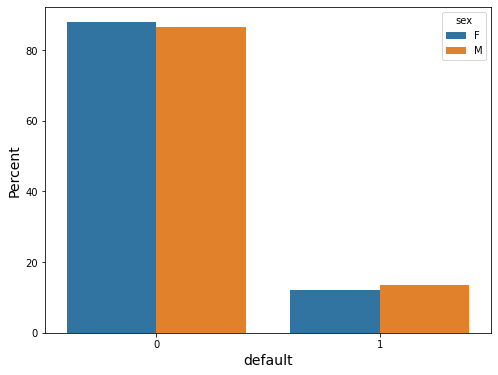

In [18]:
plt.figure(figsize=(8,6))
stat = scoring_df.groupby(['sex'])['default'] \
                .value_counts(normalize=True).rename('Percent') \
                .mul(100).reset_index() \
                .sort_values('default')
sns.barplot(x='default',y='Percent', hue='sex',data=stat)
plt.xticks(rotation=0)
plt.ylabel('Percent', fontsize=14)
plt.xlabel('default', fontsize=14)
plt.show()

In [19]:
scoring_df.groupby('sex')['sex'].count()

sex
F    41562
M    32237
Name: sex, dtype: int64

Видим, что пол не сильно влияет на target.

## 3.3 Age

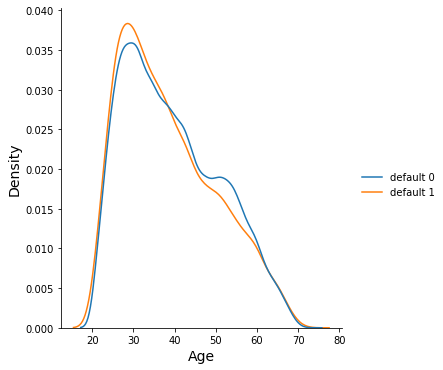

In [20]:
sns.displot({"default 0": scoring_df[scoring_df.default == 0].age , 
             "default 1": scoring_df[scoring_df.default == 1].age }, 
            kind='kde', common_norm=False)

plt.ylabel('Density', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.show()

In [21]:
scoring_df.groupby('default')['age'].median()

default
0    38.0
1    36.0
Name: age, dtype: float64

Видно, что возраст вернувших кредит заёмщиков выше, чем возраст не вернувших

## 3.4 Education

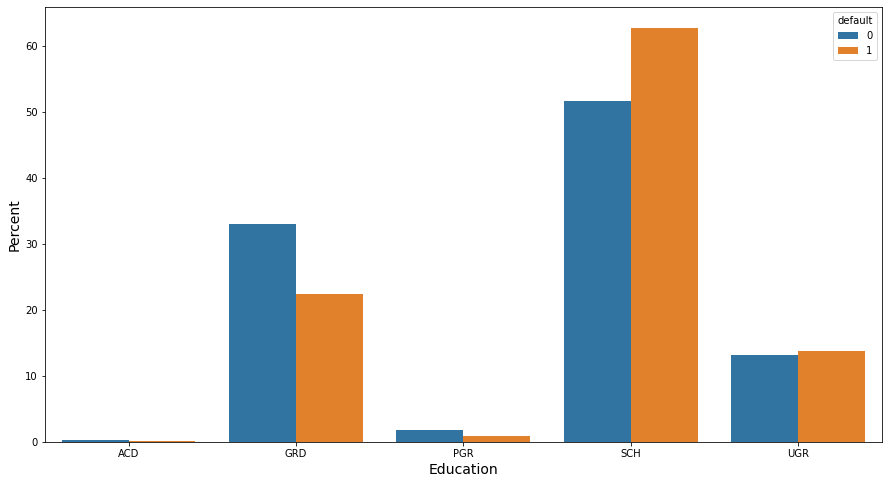

In [22]:
plt.figure(figsize=(15,8))
stat = scoring_df.groupby(['default'])['education'] \
                .value_counts(normalize=True).rename('Percent') \
                .mul(100).reset_index() \
                .sort_values('education')
sns.barplot(x='education',y='Percent', hue='default',data=stat)
plt.xticks(rotation=0)
plt.ylabel('Percent', fontsize=14)
plt.xlabel('Education', fontsize=14)
plt.show()

Уровень образования влияет на результат: GRD более стабильны в плане выплат, а SCH имеет больший процент неплательщиков, в остальных случаях примерно одинаковые пропорции.

## 3.5 good_work

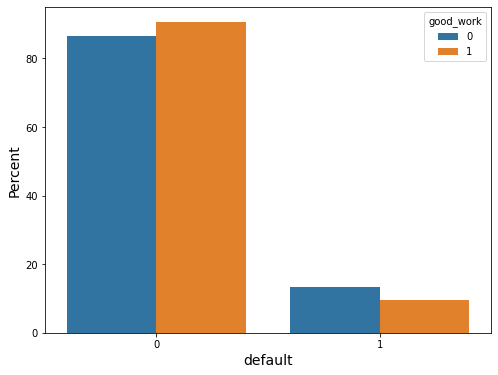

In [23]:
plt.figure(figsize=(8,6))
stat = scoring_df.groupby(['good_work'])['default'] \
                .value_counts(normalize=True).rename('Percent') \
                .mul(100).reset_index() \
                .sort_values('default')
sns.barplot(x='default',y='Percent', hue='good_work',data=stat)
plt.xticks(rotation=0)
plt.ylabel('Percent', fontsize=14)
plt.xlabel('default', fontsize=14)
plt.show()

Видим, что наличие хорошей работы имеет меньший риск дефолта клиента.

## 3.6 corr

Построим корреляцию между числовыми признаками

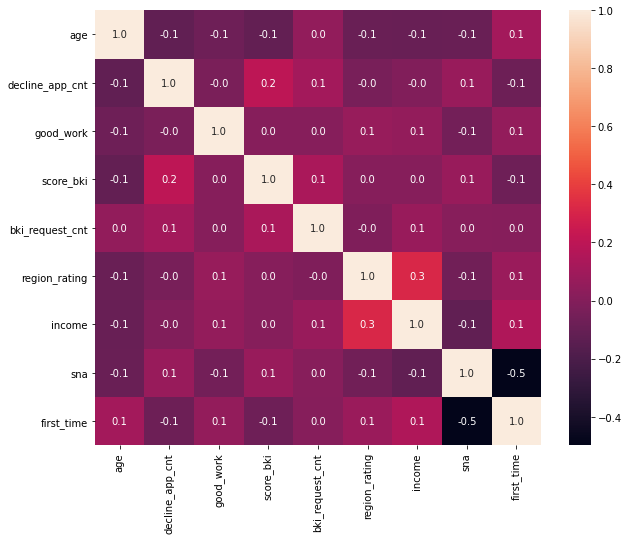

In [24]:
numeric_features = scoring_df.select_dtypes(include=['float','int'])
del numeric_features['default']
plt.figure(figsize=(10,8))
sns.heatmap(numeric_features.corr(method='spearman'), annot=True, fmt='.1f')
plt.show()

# 4 Feature engineering

Рассмотрим распределения числовых величин

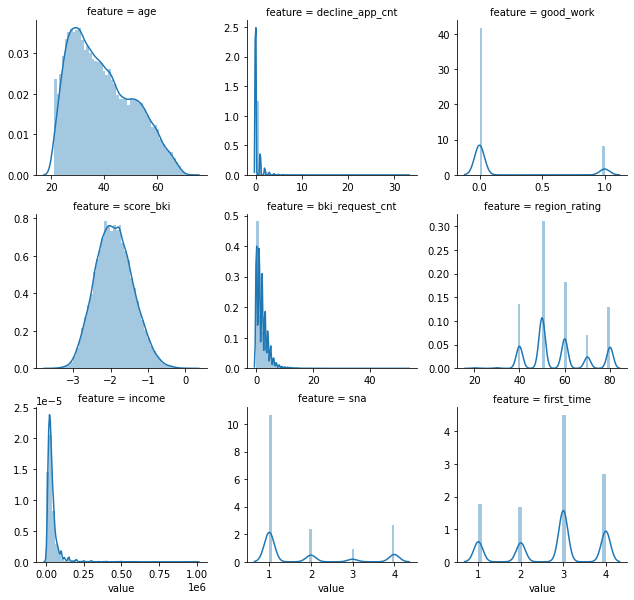

In [25]:
numeric_features = numeric_features.stack().reset_index().rename(columns={'level_1': 'feature', 0: 'value'})

ax = sns.FacetGrid(data=numeric_features, col='feature', col_wrap=3, sharex=False, sharey=False)
ax.map(sns.distplot, 'value')

plt.subplots_adjust(top=0.9)
plt.show()

Некоторые из признаков не являются нормально распределенными (хвосты смещены вправо) − нормализуем их при помощи логарифмирования

In [26]:
for column in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    scoring_df[column] = np.log(scoring_df[column] + 1)

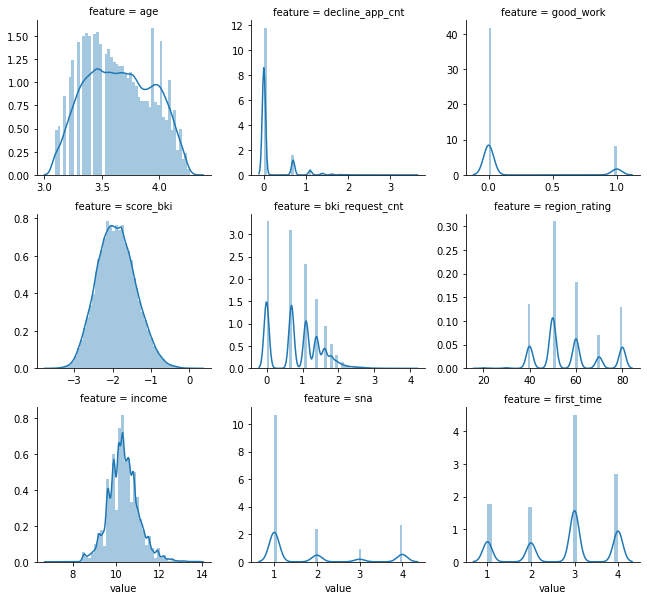

In [27]:
numeric_features = scoring_df.select_dtypes(include=['float','int'])
del numeric_features['default']
numeric_features = numeric_features.stack().reset_index().rename(columns={'level_1': 'feature', 0: 'value'})

ax = sns.FacetGrid(data=numeric_features, col='feature', col_wrap=3, sharex=False, sharey=False)
ax.map(sns.distplot, 'value')

plt.subplots_adjust(top=0.9)
plt.show()

Модели всегда проще работать с нормальными или псевдонормальными распределениями

Заменим признак `app_date` на `month`

In [28]:
scoring_df['app_date'] = pd.to_datetime(scoring_df['app_date'], format='%d%b%Y')
scoring_df['month'] = scoring_df['app_date'].dt.month.astype(object)
scoring_df.drop(['app_date'], axis=1, inplace=True)

# 5 Моделирование

Создаем обучающую и тестовую выборки


In [29]:
# бинаризация
scoring_df_ = pd.get_dummies(scoring_df, columns=['education', 'sex', 'car', 'car_type', 
                                              'home_address', 'work_address', 'foreign_passport'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(scoring_df_.loc[:, scoring_df_.columns != 'default']
                                                    ,scoring_df_['default']
                                                    ,test_size=0.25
                                                    ,stratify=scoring_df_['default'])

## 5.1 Baseline Логистическая регрессия

In [30]:
lr = LogisticRegression(class_weight = 'balanced', max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [31]:
y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [32]:
metrics = pd.DataFrame(index=['prec','rec','f1', 'roc-auc'])
metrics['LR'] = [
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_score)
]

In [33]:
metrics['LR']

prec       0.224698
rec        0.658557
f1         0.335071
roc-auc    0.725724
Name: LR, dtype: float64

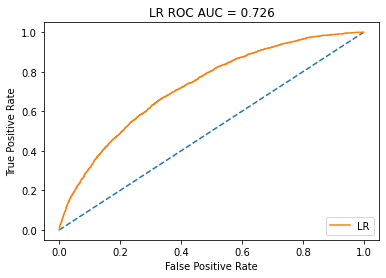

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.figure()
plt.plot([0, 1], linestyle='--')
plt.plot(fpr, tpr, label='LR')
plt.title('LR ROC AUC = %0.3f' % metrics['LR']['roc-auc'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 5.2 Градиентный бустинг

In [35]:
gb = GradientBoostingClassifier(n_estimators=50, min_samples_leaf=3)
gb.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=3, n_estimators=50)

In [36]:
y_pred = gb.predict(X_test)
y_score = gb.predict_proba(X_test)[:,1]

In [37]:
metrics['GB'] = [
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_score)
]

In [38]:
metrics['GB']

prec       0.673469
rec        0.014085
f1         0.027592
roc-auc    0.724033
Name: GB, dtype: float64

## 5.3 Сравнение логистической регрессии и градиентного бустинга

In [39]:
metrics

,LR,GB
prec,0.224698,0.673469
rec,0.658557,0.014085
f1,0.335071,0.027592
roc-auc,0.725724,0.724033


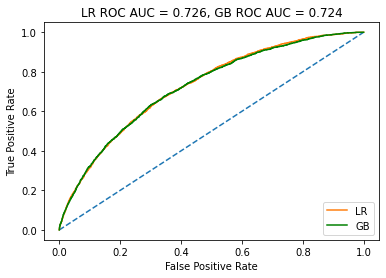

In [40]:
fpr_, tpr_, _ = roc_curve(y_test, y_score)

plt.figure()
plt.plot([0, 1], linestyle='--')
plt.plot(fpr, tpr, label='LR')
plt.plot(fpr_, tpr_, label='GB', color='g')
plt.title('LR ROC AUC = %0.3f, GB ROC AUC = %1.3f' % (metrics['LR']['roc-auc'], metrics['GB']['roc-auc']))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

По метрикам градиентный бустинг сильно улучшает точность precision по сравнению с логистической регрессией, в обмен на recall $~-$ это ведет к уменьшению остальных метрик

# 6 Анализ важных признаков

Определим, какие признаки обладают наиболее влияют результат

In [41]:
importances = pd.DataFrame(zip(X_train.columns, lr.coef_[0]))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
12,education_SCH,1.006123
3,score_bki,0.996060
13,education_UGR,0.859585
10,education_GRD,0.591502
17,home_address_2,0.561221
20,work_address_3,0.413987
1,decline_app_cnt,0.406452
19,work_address_2,0.327199
14,sex_M,0.308895
4,bki_request_cnt,0.284937
